# Final Project Rough Draft

## Introduction

### Background and Data
Pulsars radiate two rotating narrow beams of light in different directions at regular rapid intervals (Cofield, 2016). The beams of light spin and sweep across the sky instead of pointing in a single direction because they are not aligned with the pulsar's axis of rotation (Cofield, 2016). From earth, pulsars appear to be flickering stars, despite the light from the beams being steady because of the spinning that occurs. Pulsars are around the size of a city and are believed to be neutron stars, meaning they form when a star’s core collapses upon itself in a supernova (Hobbs, 2020). 


We are using the Predicting Pulsar Star dataset retrieved from Kaggle. Each observation in the dataset contains the mean, standard deviation, skewness, excess kurtosis of the integrated profile and DM-SNR Curve of each star, and each star’s observed class. The integrated profile of a pulsar is the folded signal array obtained with respect to its rotational period and signal (Liu, 2017). The shape is unique to each pulsar and can be used to distinguish pulsars from one another. The other four are concerning statistics for the DM-SNR Curve. DM-SNR stands for Dispersion Measure (how the signal of a star broadens) of the Signal to Noise Ratio (Swinburne University of Technology, 2020; The University of Sheffield, n.d.). Noise will appear in all astronomical measurements, limiting the precision of a measurement made from data. So, the Signal to Noise ratio (ratio of the signal from an astronomical source to the noise) is calculated in an attempt to estimate the noise in observations to determine if observations will be adequate (The University of Sheffield, n.d.).
Liu, K. (2017, June 26). Introduction to Pulsar, Pulsar Timing, and measuring of Pulse Time-of-Arrivals. Personal Collection of Kuo Liu, CIEP, Sèvres, France. 

<img src="https://scx2.b-cdn.net/gfx/news/hires/pulsar.gif" style="<float: right; height: 20em">
Image Credit: Imagine the Universe! at NASA/GSFC

### Question
How do different 2-D and 4-D KNN models compare for accurately classifying the type of star based on the summary statistics of a star's integrated profile and DM-SNR Curve?

How well does the best variable combination predict if a star is a pulsar?

- Change phrasing: How does the best variable combination predict if a star is a pulsar
- Compare best K's but still on training data
- Clarify question and communication in applied context

In [ ]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

#Reading the dataset and shortening the column names
pulsar_base_data = read_csv("https://raw.githubusercontent.com/NicoRui/DSCI_100_Project/main/pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) 
           
head(pulsar_base_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [ ]:
#Splitting Data
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)
print("Table 1 - Training Data")
head(pulsar_train)
print("Table 2 - Testing data")
head(pulsar_test)

In [3]:
# Table of some summary statistics fore each variable
summary(pulsar_train)

#Pulsar train and test with no NAs
pulsar_train_noNA = drop_na(pulsar_train)
pulsar_test_noNA = drop_na(pulsar_test)

#Distributional Characteristics with no NAs
summary_train_distribution = pulsar_train_noNA %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd)) %>% 
    mutate(across(where(is.numeric), round, 3))
summary_train_distribution

   mean_prof          sd_prof        kurt_prof         skew_prof      
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.625   1st Qu.:42.30   1st Qu.: 0.0230   1st Qu.:-0.1856  
 Median :115.102   Median :46.93   Median : 0.2233   Median : 0.2062  
 Mean   :110.895   Mean   :46.51   Mean   : 0.4859   Mean   : 1.8416  
 3rd Qu.:127.203   3rd Qu.:51.02   3rd Qu.: 0.4769   3rd Qu.: 0.9523  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
                                   NA's   :1410                       
   mean_DMSNR          sd_DMSNR        kurt_DMSNR       skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.945  
 1st Qu.:  1.9122   1st Qu.: 14.40   1st Qu.: 5.815   1st Qu.:  35.208  
 Median :  2.7860   Median : 18.44   Median : 8.465   Median :  83.310  
 Mean   : 12.9438   Mean   : 26.43   Mean   : 8.341   Mean   : 106.211  
 3rd Qu.:  5.3955   3rd Qu.: 28.33   3rd Qu.:10.728   3rd Qu.: 140.

target_class,mean_prof_mean,sd_prof_mean,kurt_prof_mean,skew_prof_mean,mean_DMSNR_mean,sd_DMSNR_mean,kurt_DMSNR_mean,skew_DMSNR_mean,mean_prof_sd,sd_prof_sd,kurt_prof_sd,skew_prof_sd,mean_DMSNR_sd,sd_DMSNR_sd,kurt_DMSNR_sd,skew_DMSNR_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,116.716,47.316,0.209,0.388,8.970,23.246,8.914,115.468,17.586,6.156,0.335,0.998,24.857,16.744,4.313,110.374
pulsar,56.086,38.607,3.179,16.080,51.245,56.557,2.765,18.455,30.094,8.157,1.921,14.615,46.618,20.025,3.155,48.350


In [4]:
#Standardization of all predictor variables
group_by(pulsar_train_noNA, target_class) %>% summarize(n = n())

pulsar_train_upsample_recipe = recipe(target_class~., data = pulsar_train_noNA) %>% 
        step_upsample(target_class, over_ratio = 1, skip = FALSE) %>% 
        prep()
pulsar_train_upsample = bake(pulsar_train_upsample_recipe, pulsar_train_noNA)

pulsar_recipe_train = recipe(target_class~., data = pulsar_train_upsample) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe_train, pulsar_train_upsample)

group_by(scaled_pulsar_train, target_class) %>% summarize(n = n())

pulsar_recipe_test = recipe(target_class~., data = pulsar_test_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe_test, pulsar_test_noNA)
head(scaled_pulsar_test)

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,691


Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,6711


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


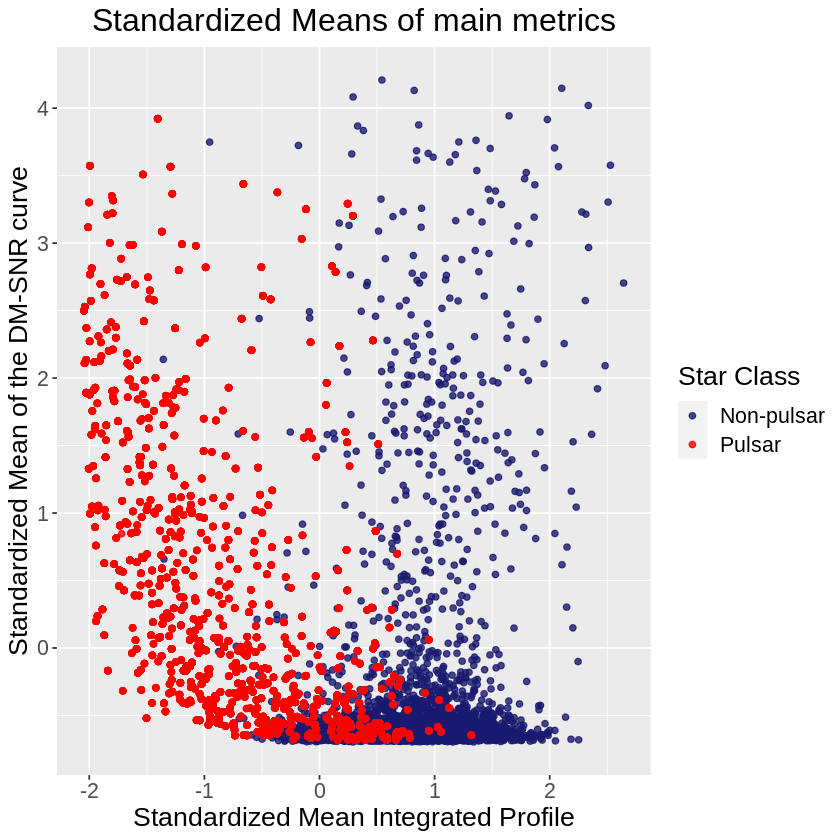

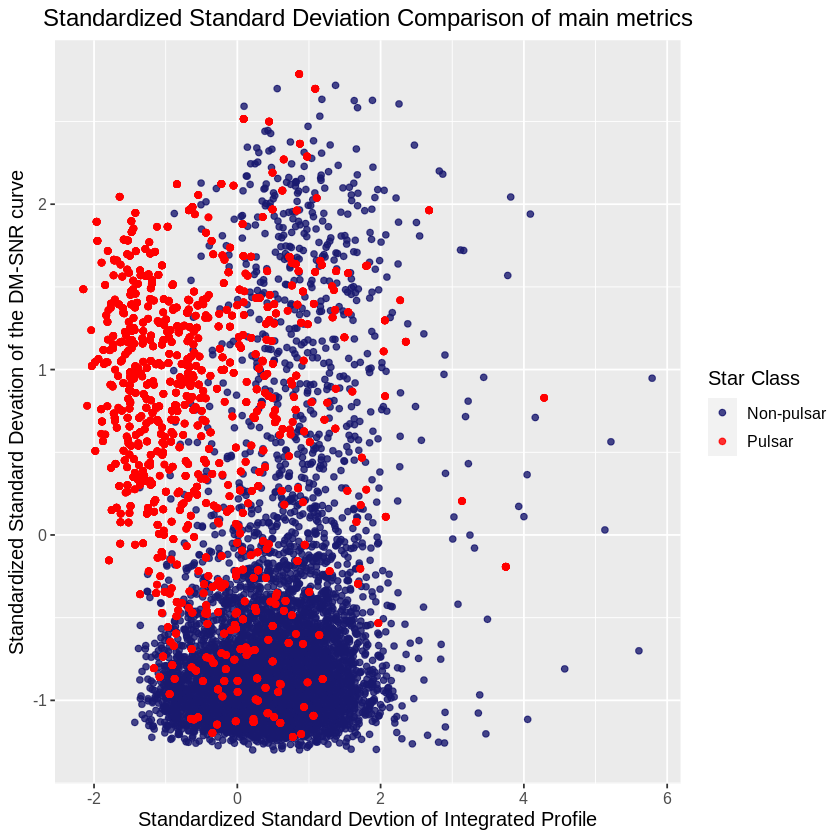

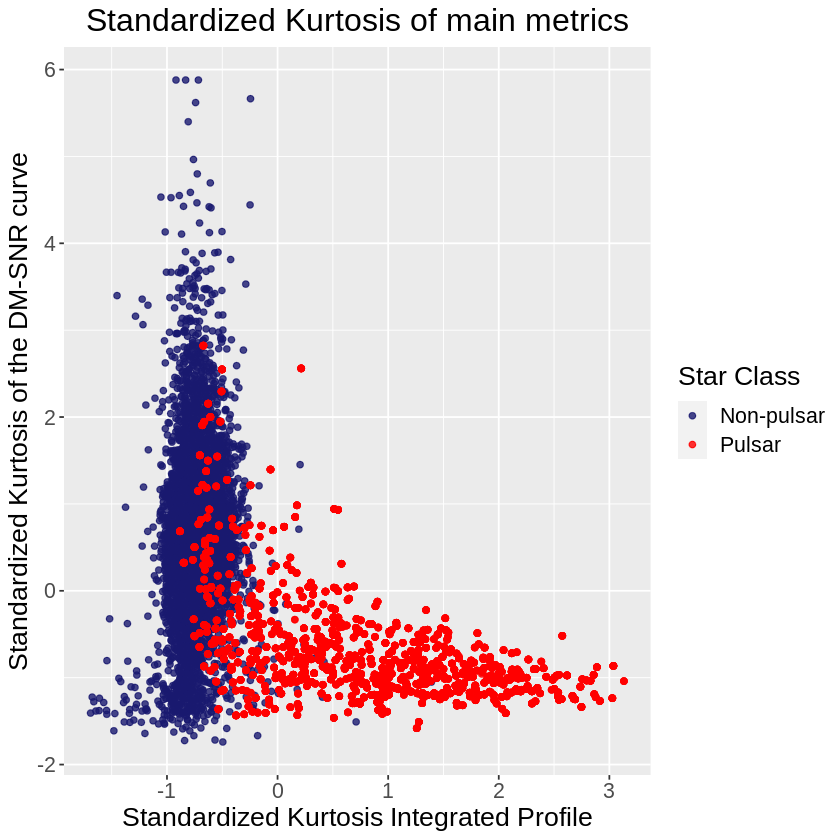

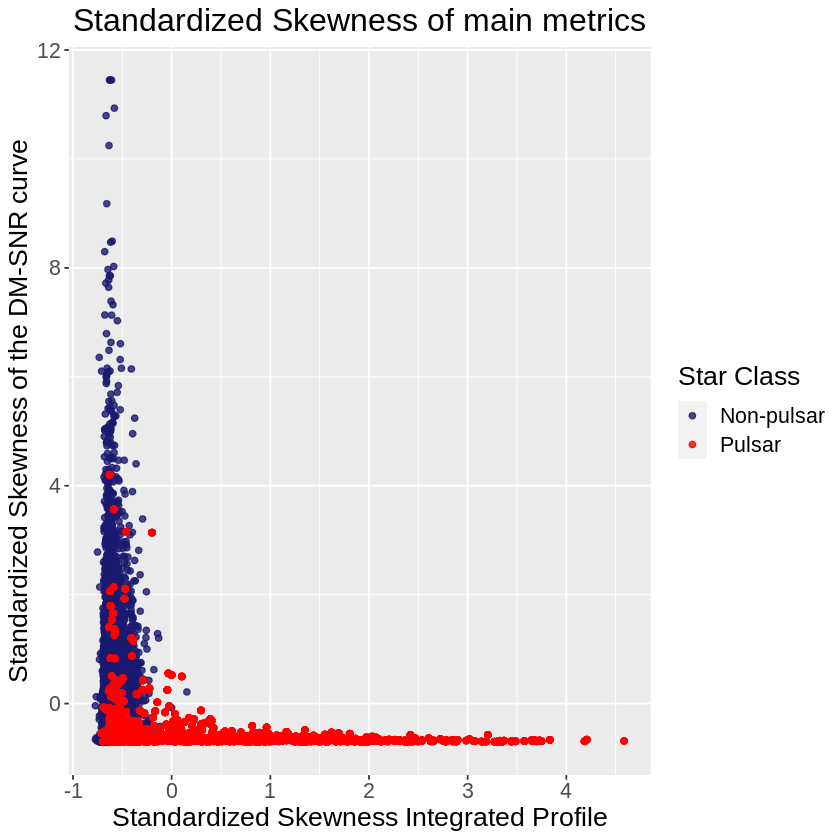

In [5]:
#Visualization for each 2-D pairing, as shown in class
mean_scaled_vis = ggplot(scaled_pulsar_train, aes(x = mean_prof, y = mean_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Mean Integrated Profile", y = "Standardized Mean of the DM-SNR curve",
           color = "Star Class", title = "Standardized Means of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
mean_scaled_vis

sd_scaled_vis = ggplot(scaled_pulsar_train, aes(x = sd_prof, y = sd_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Standard Devtion of Integrated Profile",
         y = "Standardized Standard Devation of the DM-SNR curve",
           color = "Star Class", 
         title = "Standardized Standard Deviation Comparison of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
sd_scaled_vis

kurt_scaled_vis = ggplot(scaled_pulsar_train, aes(x = kurt_prof, y = kurt_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Kurtosis Integrated Profile",
         y = "Standardized Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Standardized Kurtosis of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
kurt_scaled_vis

skew_scaled_vis = ggplot(scaled_pulsar_train, aes(x = skew_prof, y = skew_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Skewness Integrated Profile",
         y = "Standardized Skewness of the DM-SNR curve",
           color = "Star Class", title = "Standardized Skewness of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
skew_scaled_vis

## Models
### Means Model

In [6]:
mean_recipe_train <-recipe(target_class~mean_prof+mean_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_mean_train <- bake(mean_recipe_train, scaled_pulsar_train)

mean_recipe_test <- recipe(target_class~ mean_prof + mean_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_mean_test <- bake(mean_recipe_train, scaled_pulsar_test)
set.seed(781)
gridvals = tibble(neighbors = seq(1,20))
mean_vfold <- vfold_cv(scaled_mean_train, v = 5, strata = target_class)
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

In [7]:
set.seed(781)
mean_fit <- workflow()%>%
add_recipe(mean_recipe_train)%>%
add_model(knn_spec)%>%
tune_grid(resamples = mean_vfold, grid = gridvals)%>%
collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839072,5,0.0008014114,Model01


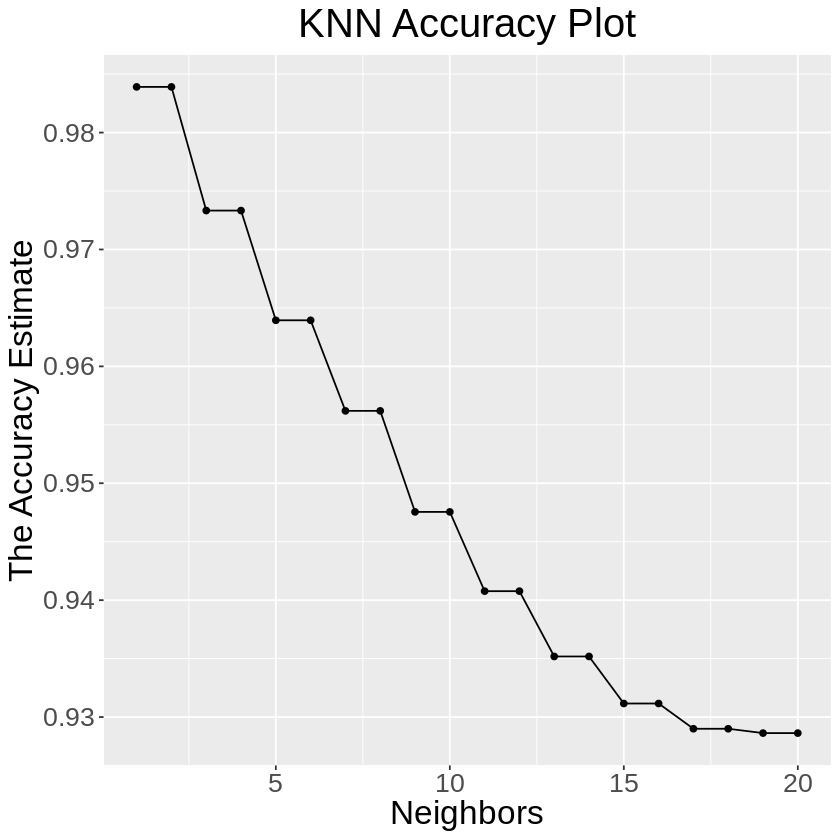

In [27]:
meanFitAccuracy <- filter(mean_fit, .metric == "accuracy")

accuracy_plot_mean <- ggplot(meanFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_mean

BestKaccuracyMean <- meanFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)
BestKaccuracyMean

### Standard Deviation Model

In [9]:
#Standardization of all predictor variables
sd_recipe_train = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_sd_train = bake(sd_recipe_train, scaled_pulsar_train)
head(scaled_sd_train)

sd_recipe_test = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_sd_test = bake(sd_recipe_test, scaled_pulsar_test)
head(scaled_sd_test)
set.seed(781)
sd_vfold = vfold_cv(scaled_sd_train, v = 5, strata = target_class)   

sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.6460178,-0.8591879,non_pulsar
-0.7985320,-0.8922846,non_pulsar
1.2211844,-0.7008429,non_pulsar
-0.8053889,-0.7705444,non_pulsar
1.5389328,-0.8153520,non_pulsar
-0.3195683,-0.8664446,non_pulsar


sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.002139272,-0.498483074,non_pulsar
-0.187662501,0.001776142,non_pulsar
0.140952188,-0.177872560,non_pulsar
0.138825140,-0.220226313,non_pulsar
-0.885023856,-0.259193888,non_pulsar
0.430033563,0.157397274,non_pulsar


In [10]:
set.seed(781)
sd_fit = workflow() %>% 
    add_recipe(sd_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = sd_vfold, grid = gridvals) %>% 
    collect_metrics() 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9769779,5,0.00151582,Model01


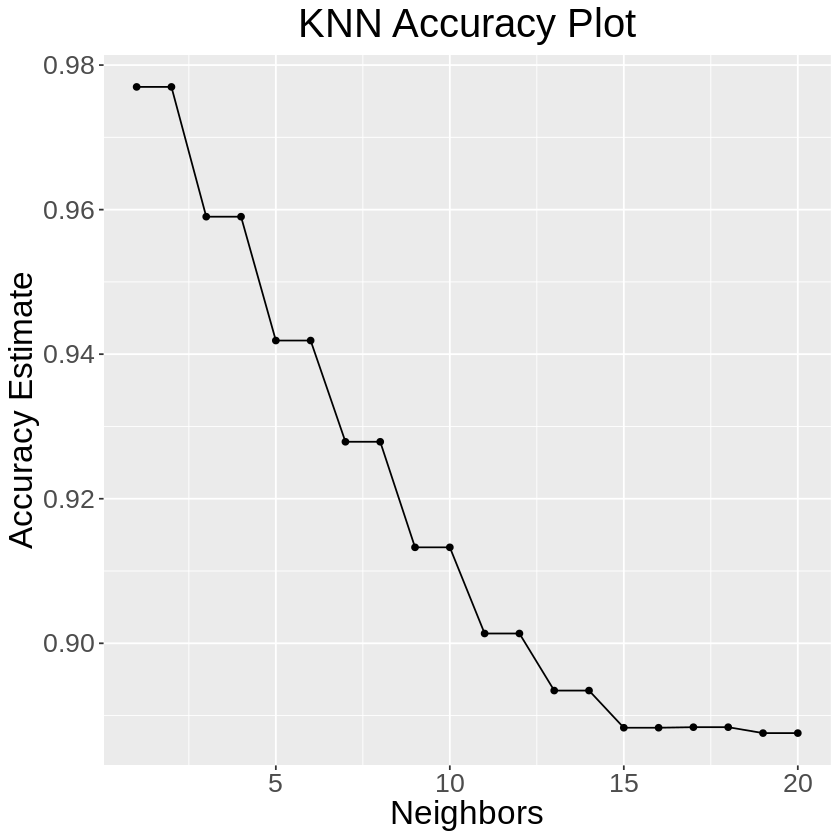

In [28]:
sdFitAccuracy = filter(sd_fit, .metric == "accuracy")

ACC_plot_SD = ggplot(sdFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_SD

BestKaccuracySD <- sdFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)
BestKaccuracySD

### Skewness Model

In [12]:
#Standardization of all predictor variables
skew_recipe_train = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_skew_train = bake(skew_recipe_train, scaled_pulsar_train)
head(scaled_skew_train)

skew_recipe_test = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_test) %>%
                    prep()
scaled_skew_test = bake(skew_recipe_test, scaled_pulsar_test)
head(scaled_skew_test)

set.seed(781)
skew_vfold = vfold_cv(scaled_skew_train, v = 5, strata = target_class)

skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6371058,-0.02131540,non_pulsar
-0.3762494,0.36139647,non_pulsar
-0.6588888,0.06907591,non_pulsar
-0.3850364,0.09209958,non_pulsar
-0.6317833,0.30690514,non_pulsar
-0.5476717,0.03617379,non_pulsar


skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.28857476,-0.05490509,non_pulsar
-0.31459801,-0.55910137,non_pulsar
-0.27962898,-0.44353091,non_pulsar
-0.30184039,-0.31283473,non_pulsar
-0.01691419,-0.29278131,non_pulsar
-0.33386356,-0.66868236,non_pulsar


In [13]:
set.seed(781)
skew_fit = workflow() %>%
    add_recipe(skew_recipe_train) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = skew_vfold, grid = gridvals) %>%
    collect_metrics()

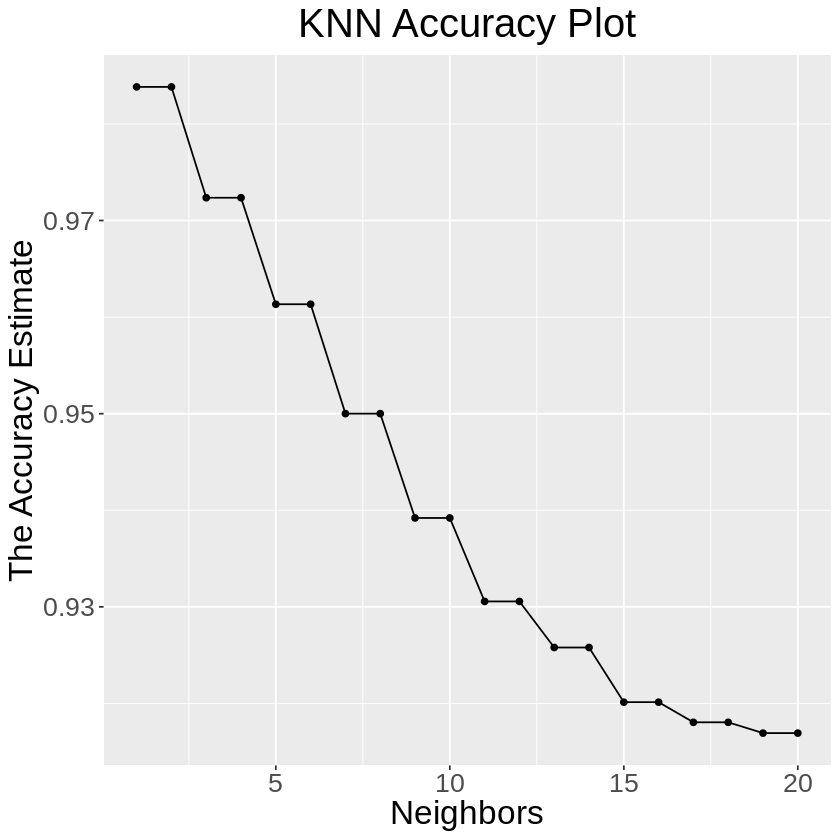

In [29]:
skewFitAccuracy <- filter(skew_fit, .metric == "accuracy")

accuracy_plot_skew <- ggplot(skewFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_skew

In [15]:
BestKaccSkew = skewFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccSkew

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9838334,5,0.001706795,Model01


### Kurtosis Model

In [33]:
#Standardization of all predictor variables
kurt_recipe_train = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_kurt_train = bake(kurt_recipe_train, scaled_pulsar_train)
head(scaled_kurt_train)
kurt_recipe_test = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_kurt_test = bake(kurt_recipe_test, scaled_pulsar_test)
head(scaled_kurt_test)
set.seed(781)
kurt_vfold = vfold_cv(scaled_kurt_train, v = 5, strata = target_class)

kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6514908,0.3270835,non_pulsar
-0.4855848,0.7297811,non_pulsar
-0.7705197,0.5440298,non_pulsar
-0.4304579,0.5228462,non_pulsar
-0.5582541,0.7356491,non_pulsar
-0.6652125,0.4093396,non_pulsar


kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.18496543,0.24305640,non_pulsar
-0.49151524,-0.33098399,non_pulsar
-0.22459219,-0.19184137,non_pulsar
-0.24399215,0.02768594,non_pulsar
0.08090689,-0.06350674,non_pulsar
-0.32417289,-0.53718862,non_pulsar


In [34]:
set.seed(781)
kurt_fit = workflow() %>% 
    add_recipe(kurt_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = kurt_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.986589,5,0.000677801,Model01


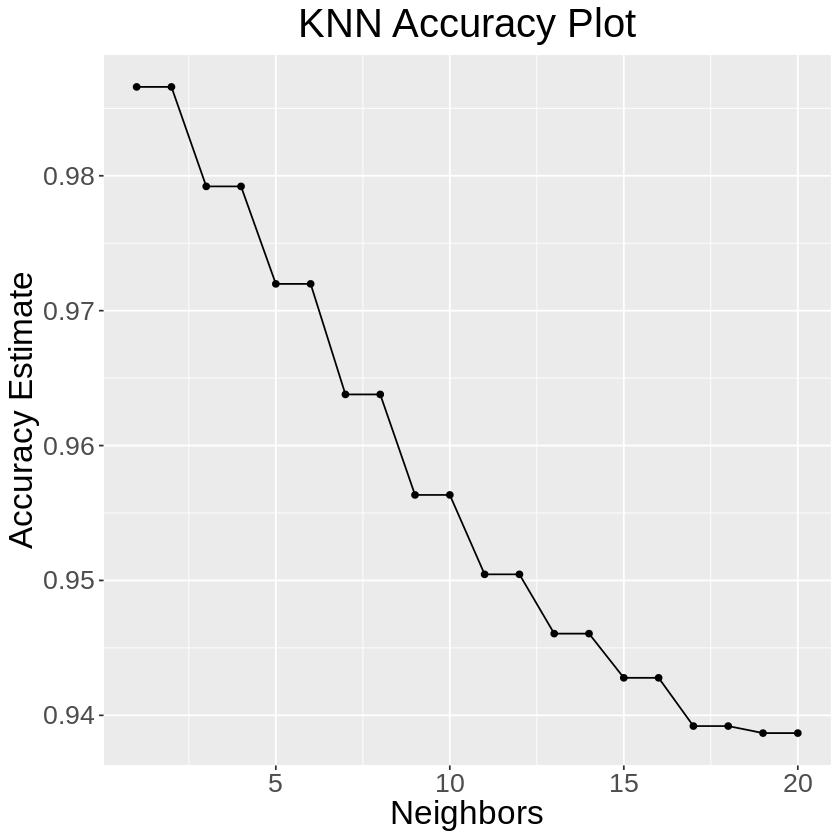

In [35]:
kurtFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot_kurt = ggplot(kurtFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_kurt

BestKaccKurt = kurtFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccKurt

### Profile Model

In [36]:
#Standardization of all predictor variables
profile_recipe_train = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_train) %>% 
                    prep()
scaled_profile_train = bake(profile_recipe_train, scaled_pulsar_train)
head(scaled_profile_train)

profile_recipe_test = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_test) %>% 
                    prep()
scaled_profile_test = bake(profile_recipe_test, scaled_pulsar_test)
head(scaled_profile_test)

set.seed(781)
profile_vfold = vfold_cv(scaled_profile_train, v = 5, strata = target_class)

mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.8900741,0.6460178,-0.6514908,-0.6371058,non_pulsar
-0.2386530,-0.7985320,-0.4855848,-0.3762494,non_pulsar
1.1309464,1.2211844,-0.7705197,-0.6588888,non_pulsar
-0.0384915,-0.8053889,-0.4304579,-0.3850364,non_pulsar
0.5899317,1.5389328,-0.5582541,-0.6317833,non_pulsar
0.2221375,-0.3195683,-0.6652125,-0.5476717,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,non_pulsar


In [37]:
set.seed(781)
profile_fit = workflow() %>% 
    add_recipe(profile_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = profile_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9881544,5,0.001117994,Model01


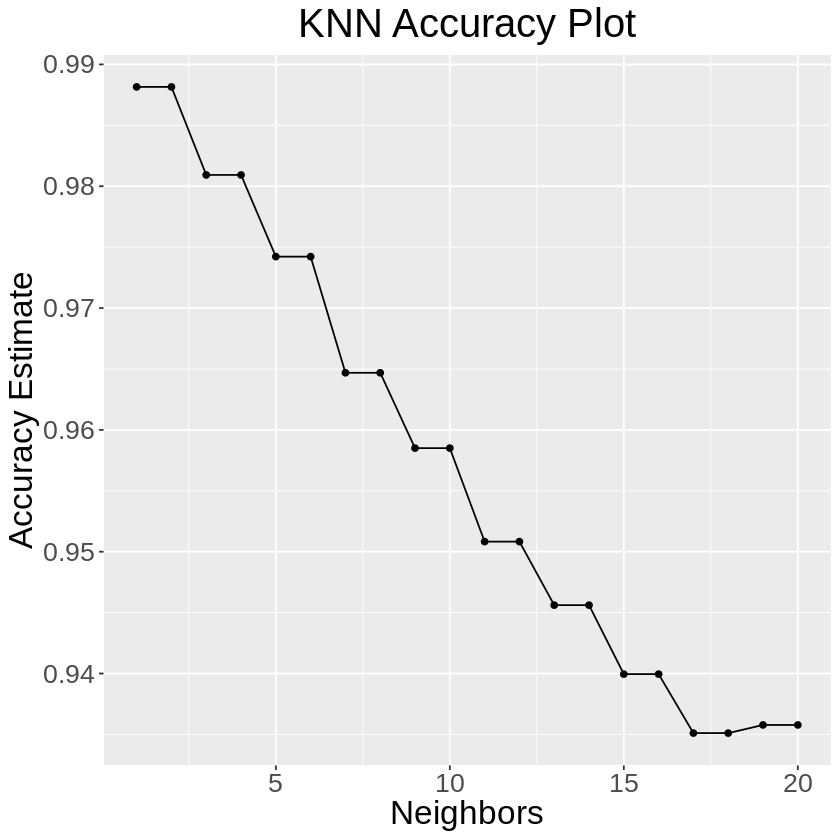

In [38]:
ProfFitAccuracy = filter(profile_fit, .metric == "accuracy")

ACC_plot_prof = ggplot(ProfFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_prof

BestKaccProf = ProfFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccProf

### DMSNR Model

In [39]:
#Standardization of all predictor variables
DMSNR_recipe_train = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_DMSNR_train = bake(DMSNR_recipe_train, scaled_pulsar_train)
head(scaled_DMSNR_train)

DMSNR_recipe_test = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_DMSNR_test = bake(DMSNR_recipe_test, scaled_pulsar_test)
head(scaled_DMSNR_test)

set.seed(781)
DMSNR_vfold = vfold_cv(scaled_DMSNR_train, v = 5, strata = target_class)

mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.6281189,-0.8591879,0.3270835,-0.02131540,non_pulsar
-0.6459383,-0.8922846,0.7297811,0.36139647,non_pulsar
-0.6379777,-0.7008429,0.5440298,0.06907591,non_pulsar
-0.6368930,-0.7705444,0.5228462,0.09209958,non_pulsar
-0.6367187,-0.8153520,0.7356491,0.30690514,non_pulsar
-0.6373579,-0.8664446,0.4093396,0.03617379,non_pulsar


mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


In [40]:
set.seed(781)
DMSNR_fit = workflow() %>% 
    add_recipe(DMSNR_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = DMSNR_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9730301,5,0.001561857,Model01


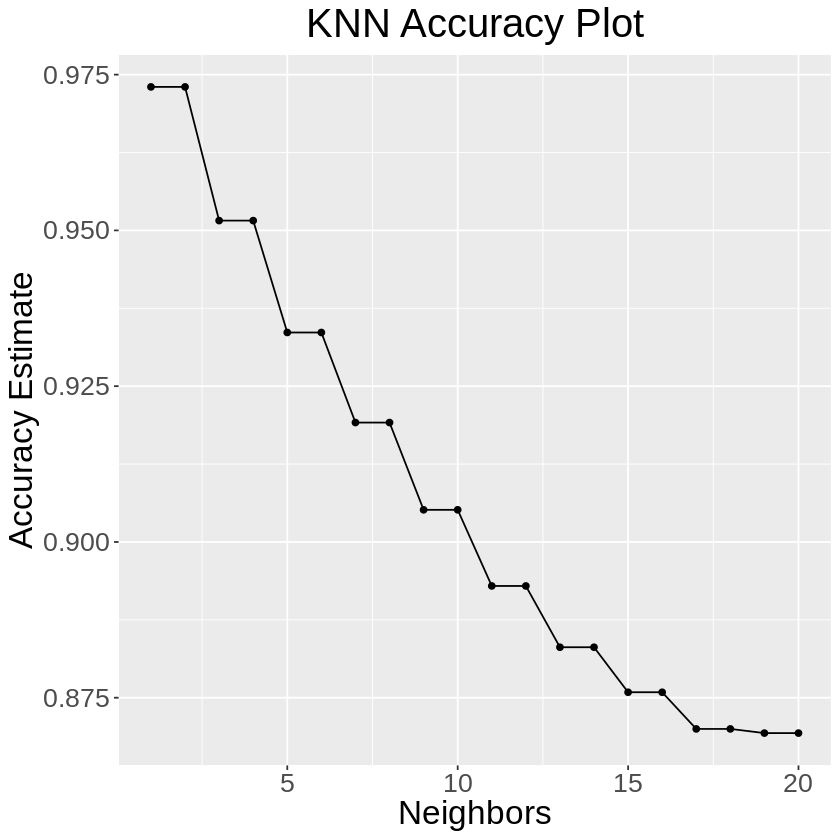

In [41]:
DMSNRFitAccuracy = filter(DMSNR_fit, .metric == "accuracy")

ACC_plot = ggplot(DMSNRFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

BestKaccDMSNR = DMSNRFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccDMSNR

In [43]:
TrainAccuracies = tibble(rbind(BestKaccuracyMean, BestKaccuracySD, BestKaccSkew, 
                               BestKaccKurt, BestKaccProf, BestKaccDMSNR))
TrainAccuracies

AlsoBestKurtK = kurtFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(2)
AlsoBestKurtK

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839072,5,0.0008014114,Model01
1,accuracy,binary,0.9769779,5,0.0015158202,Model01
1,accuracy,binary,0.9838334,5,0.0017067954,Model01
1,accuracy,binary,0.9865890,5,0.0006778010,Model01
1,accuracy,binary,0.9881544,5,0.0011179943,Model01
1,accuracy,binary,0.9730301,5,0.0015618574,Model01


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.986589,5,0.000677801,Model02


In [48]:
kurtFitROC_AUC = filter(kurt_fit, .metric == "roc_auc")
slice(kurtFitROC_AUC, 1:6)

ProfFitROC_AUC = filter(profile_fit, .metric == "roc_auc")
slice(ProfFitROC_AUC, 1:6)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,roc_auc,binary,0.9865890,5,0.0006778010,Model01
2,roc_auc,binary,0.9865890,5,0.0006778010,Model02
3,roc_auc,binary,0.9865843,5,0.0007147932,Model03
4,roc_auc,binary,0.9866539,5,0.0005946706,Model04
5,roc_auc,binary,0.9869677,5,0.0006150943,Model05
6,roc_auc,binary,0.9874165,5,0.0007569543,Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,roc_auc,binary,0.9881544,5,0.0011179943,Model01
2,roc_auc,binary,0.9883651,5,0.0009231399,Model02
3,roc_auc,binary,0.9886880,5,0.0008766631,Model03
4,roc_auc,binary,0.9886648,5,0.0008531857,Model04
5,roc_auc,binary,0.9891112,5,0.0008439891,Model05
6,roc_auc,binary,0.9895193,5,0.0010193926,Model06


Comparing the accuracies of the best K values of the, we see that $k=1$ for all of the model's best accuracies

## References

Cofield, C. (2016, April 22). What Are Pulsars? Space.com. 
https://www.space.com/32661-pulsars.html. 

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & 
Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17=

Hobbs, M. (2020, November 17). An Introduction to Pulsars. Australia Telescope National 
Facility. https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html.

Lounge, C.-learning. (2020, August 26). Predicting Pulsar Star. Kaggle. 
https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate?select=pulsar_data_train.csv. 

Rowan, L., & Coontz, R. (2004, April 23). The Strange and Twisted World of Pulsars. 
Science. https://science.sciencemag.org/content/304/5670/531.  

Lyon, R. (2017, February 14). HTRU2 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/HTRU2

Swinburne University of Technology. (2020). Pulsar Dispersion Measure. COSMOS. https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure

The University of Sheffield. (n.d.). L14 Signal-to-Noise. PHY217 Observational Techniques for Astronomers. http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html